### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 29th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

Part 1

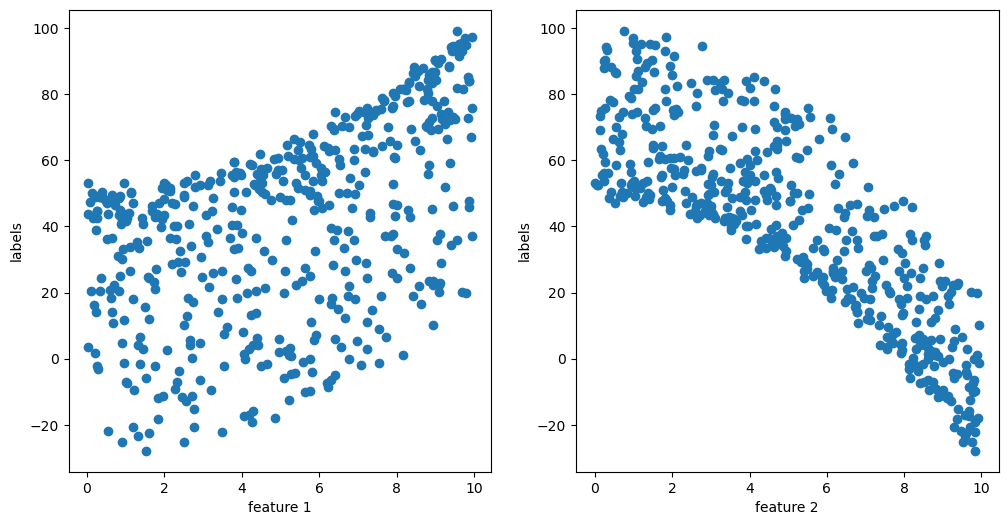

In [57]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#load in data
hw_data = np.load("../../../homeworks/hw_data/hw7_data_1.npy")
feature1 = hw_data[:,0]
feature2 = hw_data[:,1]
labels = hw_data[:,2]
errors = hw_data[:,3]

#plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))

ax1.scatter(feature1,labels)
ax1.set_xlabel('feature 1')
ax1.set_ylabel('labels')
ax2.scatter(feature2,labels)
ax2.set_xlabel('feature 2')
ax2.set_ylabel('labels')
plt.show()

Part 2

In [58]:
#perform Linear Regression
from astroML.linear_model import LinearRegression

Features = np.vstack((feature1, feature2)).T #make features 2D
dytest = errors # heteroscedastic errors

model = LinearRegression()
model.fit(Features, labels, dytest) #fit 

intercept = model.coef_[0]
slopes = model.coef_[1:]
print('the best fit intercept is:', intercept)
print('the best fit slopes:', slopes)


the best fit intercept is: 57.1010232329955
the best fit slopes: [ 4.94873016 -8.30023407]


SRT: Good!

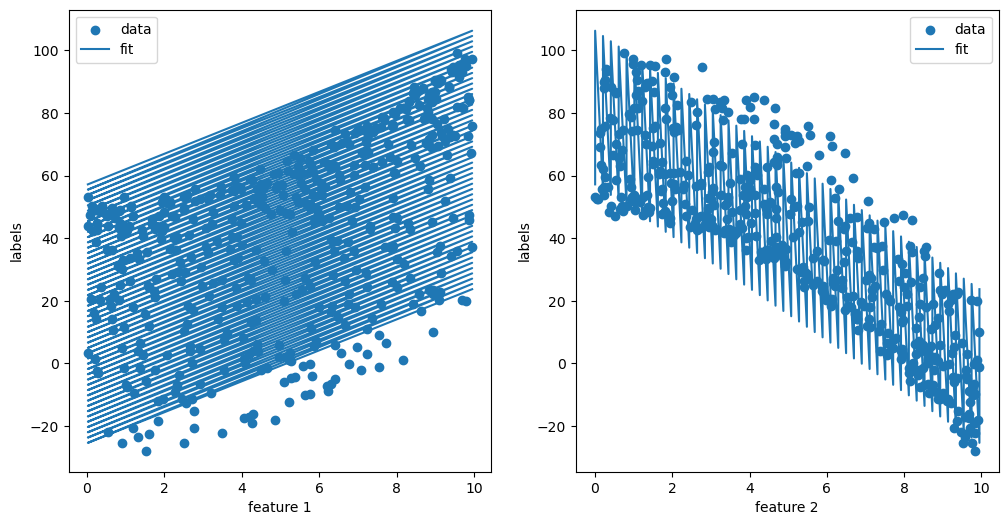

In [59]:
#make meshgrid of features
u = np.linspace(min(feature1),max(feature1),50)
v = np.linspace(min(feature2),max(feature2),50) 
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

#predict labels on grid
y_pred = model.predict(Xgrid)

#plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))

ax1.scatter(feature1,labels, label='data')
ax1.plot(Xgrid[:,0],y_pred, label='fit')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('labels')
ax1.legend()
ax2.scatter(feature2,labels,label='data')
ax2.plot(Xgrid[:,1],y_pred, label='fit')
ax2.set_xlabel('feature 2')
ax2.set_ylabel('labels')
ax2.legend()
plt.show()

This is not a terrible description of the data, but it overfits in some places while underfitting in others. The data is not linear while the fit is.

Part 3

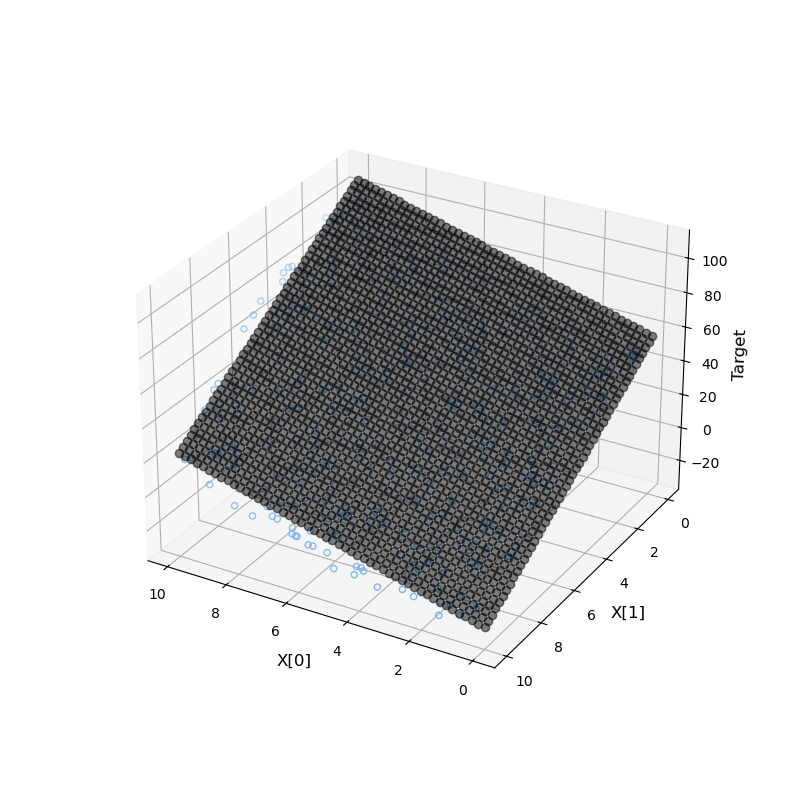

In [60]:
%matplotlib widget 

u = np.linspace(min(feature1),max(feature1),50)
v = np.linspace(min(feature2),max(feature2),50) 
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
y_pred = model.predict(Xgrid)

#plot in 3D
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_pred, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1, feature2, labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
plt.show()
%matplotlib inline


Part 4

the best params: {'alpha': 1.0, 'solver': 'svd'}
the best score: 0.9290800590702192


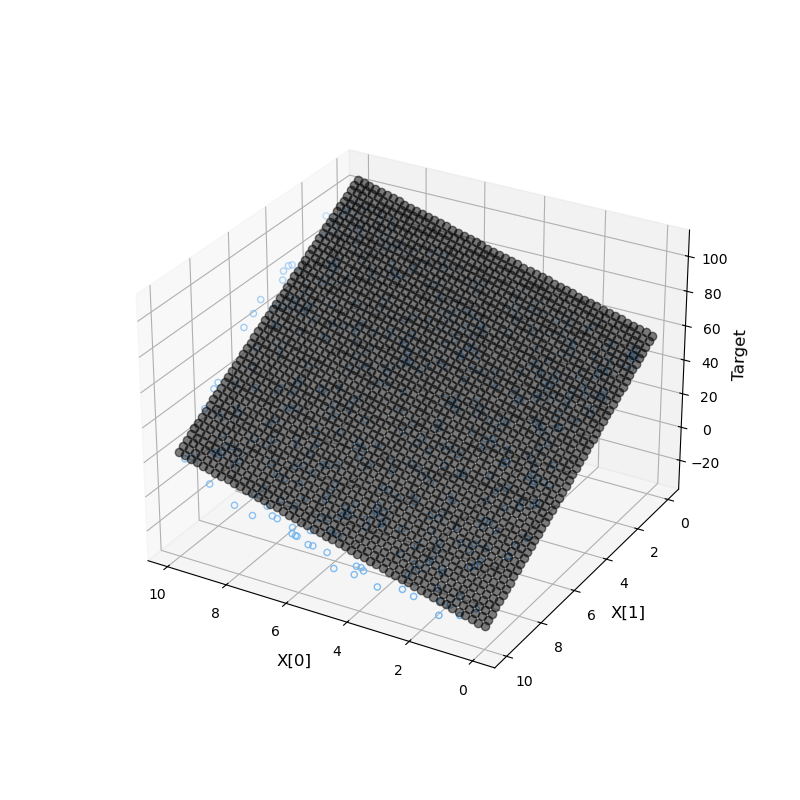

In [61]:
#Ridge Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
%matplotlib widget 


ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']} #ridge params
ridge = Ridge()


grid = GridSearchCV(estimator=ridge, param_grid=ridge_params, refit=True) 
#fit data
grid.fit(Features,labels)

print('the best params:', grid.best_params_)
print('the best score:', grid.best_score_)

#make prediction
y_pred = grid.predict(Xgrid)

#plot 3D
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_pred, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1, feature2, labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
plt.show()
%matplotlib inline


SRT: You should also account for uncertainties in the fit here, Azeem. You can do this with sample_weight. -1 point

In [62]:
#using RidgeCV
from sklearn.linear_model import RidgeCV
clf = RidgeCV(fit_intercept=True)
clf.fit(Features, labels)
print('alpha:', clf.alpha_)
print('agrees with GridSearchCV!')

alpha: 1.0
agrees with GridSearchCV!


SRT: great!

Part 5

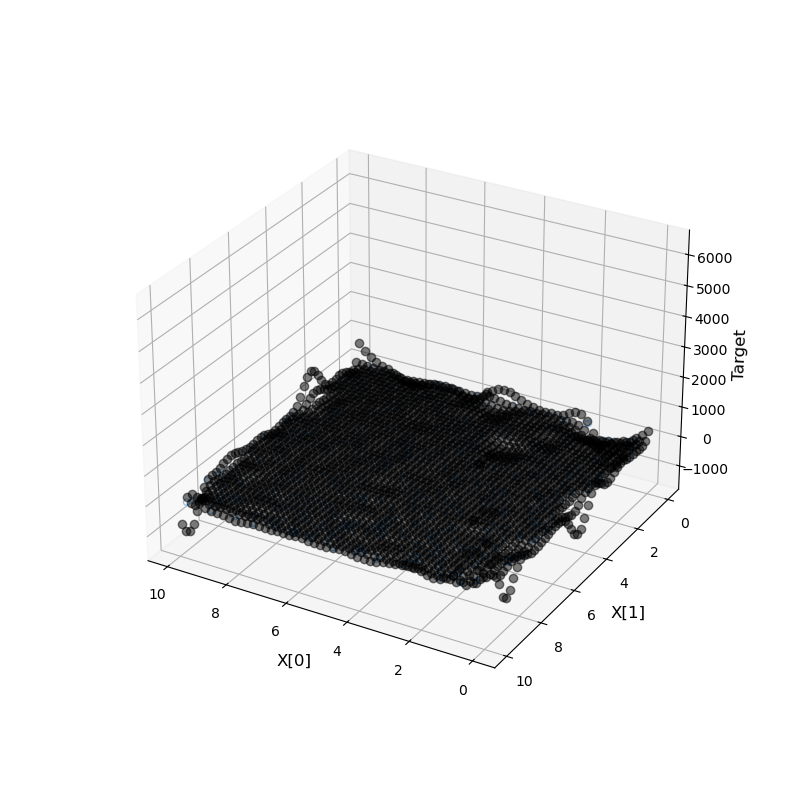

In [63]:
#using GPR
from sklearn.gaussian_process import GaussianProcessRegressor

#fit without yerr
gp1 = GaussianProcessRegressor(random_state=0)
gp1.fit(Features,labels)
y_pred1 = gp1.predict(Xgrid)

%matplotlib widget 

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_pred1, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1, feature2, labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
plt.show()
%matplotlib inline


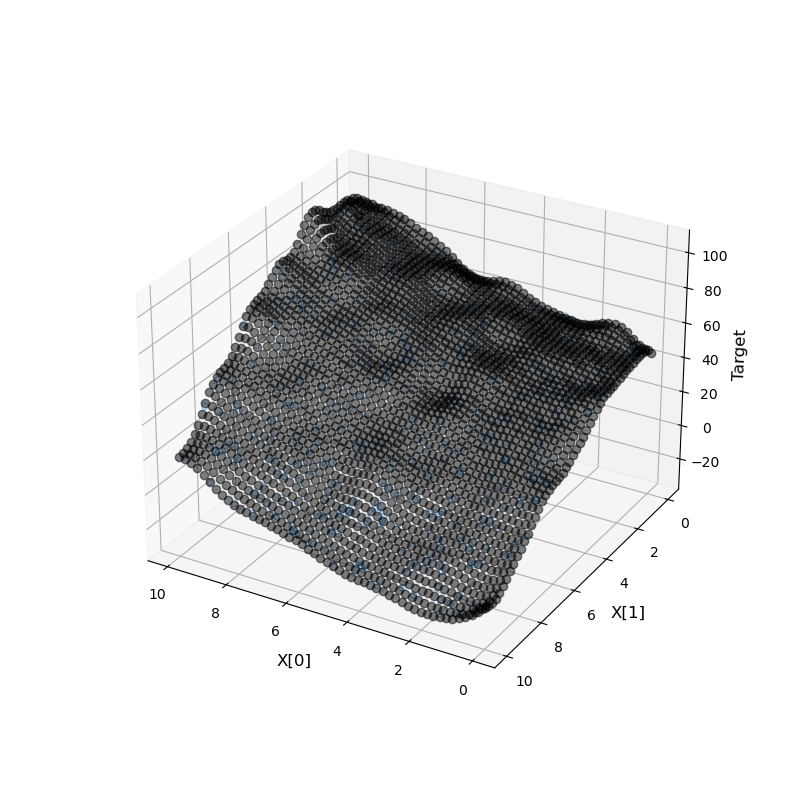

In [64]:
#fit with yerr
%matplotlib widget 

gp2 = GaussianProcessRegressor(alpha=(errors/ labels) ** 2, random_state=0)
gp2.fit(Features,labels)
y_pred2 = gp2.predict(Xgrid)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_pred2, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1, feature2, labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
plt.show()
%matplotlib inline


Part 6

best-fit regression coefficients: [ 5.00363666e+01  3.26437755e-01  7.04566290e-02  3.76478281e-01
 -2.37398556e-02 -8.70986046e-01  1.19122182e-02  2.54637597e-02
 -1.32002013e-02  2.02705370e-02 -4.53796076e-04 -5.21142180e-04
 -2.06194460e-03  1.68744189e-03 -1.52054198e-03]


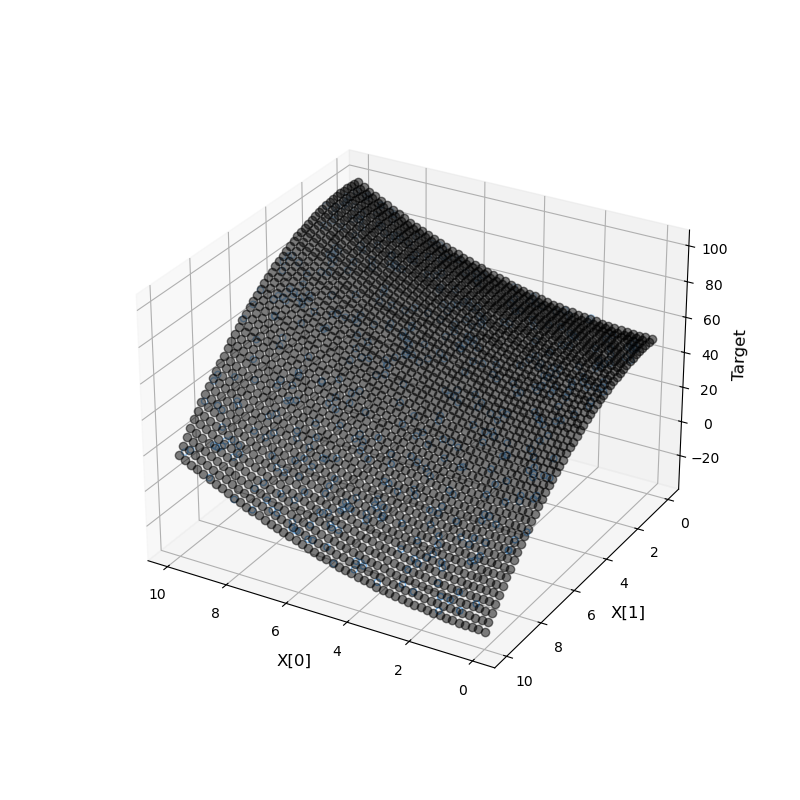

In [65]:
#using Polynomial Regression
from astroML.linear_model import PolynomialRegression
poly = PolynomialRegression(degree=4) #4th degree
poly.fit(Features,labels)
print('best-fit regression coefficients:', poly.coef_)
y_plot = poly.predict(Xgrid) #predict

#plot
%matplotlib widget 

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_plot, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1, feature2, labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
plt.show()

SRT: Data uncertainties? -1 point

Fitting a 4th-degree polynomial seems to work really well. It's more smooth than the GPR and overall fits the data better than the linear models.

Part 7

In [66]:
from sklearn.model_selection import train_test_split
#split the data into training set and test set
X_train, X_test, y_train, y_test, error_train, error_test = train_test_split(Features, labels, errors,test_size=0.2, random_state=42)
#split again for cross validation
cv_x_train, cv_x_test, cv_y_train, cv_y_test, cv_error_train, cv_error_test = train_test_split(X_train, y_train, error_train,test_size=0.2, random_state=42)

In [67]:
degree = np.arange(1,11)
training_err = np.zeros(len(degree))
crossval_err = np.zeros(len(degree))
for i in range(len(degree)):
    poly_reg = PolynomialRegression(degree=i+1)
    poly_reg.fit(cv_x_train, cv_y_train, cv_error_train) #fit

    y_train_pred = poly_reg.predict(cv_x_train)
    cv_y_pred = poly_reg.predict(cv_x_test)

    training_err[i] = np.sqrt(np.sum((y_train_pred - cv_y_train)**2 / len(cv_y_train)))
    crossval_err[i] = np.sqrt(np.sum((cv_y_pred - cv_y_test)**2 / len(cv_y_test)))

BIC_train = np.sqrt(len(cv_y_train)) * training_err / np.mean(cv_error_train) + degree * np.log(len(cv_y_train))
BIC_crossval = np.sqrt(len(cv_y_test)) * crossval_err / np.mean(cv_error_test) + degree * np.log(len(cv_y_test))

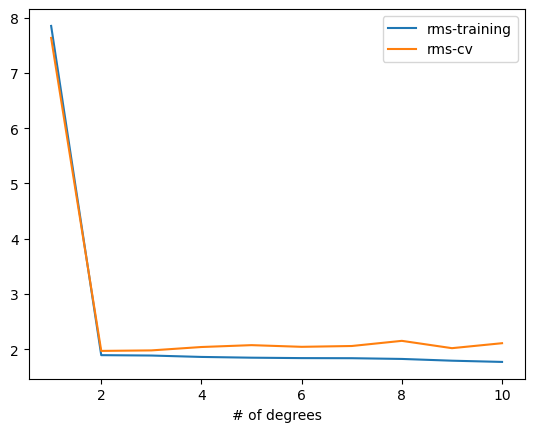

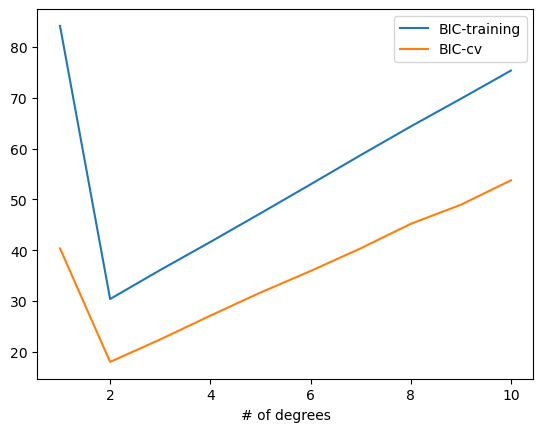

In [69]:
%matplotlib inline
plt.plot(degree,training_err, label='rms-training')
plt.plot(degree, crossval_err, label='rms-cv')
plt.xlabel('# of degrees')
plt.legend()
plt.show()
plt.plot(degree,BIC_train, label='BIC-training')
plt.plot(degree, BIC_crossval, label='BIC-cv')
plt.xlabel('# of degrees')
plt.legend()
plt.show()

In [70]:
poly_reg = PolynomialRegression(degree=2)
poly_reg.fit(X_train, y_train, error_train)
y_test_pred = poly_reg.predict(X_test)
test_err = np.sqrt(np.sum((y_test_pred - y_test)**2 / len(y_test)))
print('the testing rms error is:', test_err)

the testing rms error is: 1.9492137379315944


SRT: Good work, Azeem. It would be more appropriate to have the data uncertainties weight each calculation of the fit departure from the data, like in a chi-squared calculation. At the moment you just have a division by a mean uncertainty. -1 point

47/50